<a href="https://colab.research.google.com/github/atariqbscs/CanvasInsight/blob/master/Detecting_children_emotions_using_pytorch%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting emotions in children’s drawings

**Installing Dependencies:**

In [1]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
#!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

5.3.0
     |████████████████████████████████| 484.0MB 1.2MB/s 
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.4.0 which is incompatible.
ERROR: fastai 1.0.57 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
     |████████████████████████████████| 748.9MB 19kB/s 
  Found existing installation: torch 0.4.0
    Uninstalling torch-0.4.0:
      Successfully uninstalled torch-0.4.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from fastai import *
from pathlib import Path
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'/


In [0]:
path = Path("/gdrive/My Drive/")

In [10]:
!unzip Children_emotion.zip

Archive:  Children_emotion.zip
   creating: Children_emotions/Train/
   creating: Children_emotions/Train/depression/
  inflating: Children_emotions/Train/depression/1.jpg  
  inflating: Children_emotions/Train/depression/100.jpg  
  inflating: Children_emotions/Train/depression/101.jpg  
  inflating: Children_emotions/Train/depression/102.jpg  
  inflating: Children_emotions/Train/depression/103.jpg  
  inflating: Children_emotions/Train/depression/104.jpg  
  inflating: Children_emotions/Train/depression/105.jpg  
  inflating: Children_emotions/Train/depression/106.jpg  
  inflating: Children_emotions/Train/depression/107.jpg  
  inflating: Children_emotions/Train/depression/108.jpg  
  inflating: Children_emotions/Train/depression/11.jpg  
  inflating: Children_emotions/Train/depression/110.jpg  
  inflating: Children_emotions/Train/depression/111.jpg  
  inflating: Children_emotions/Train/depression/112.jpg  
  inflating: Children_emotions/Train/depression/113.jpg  
  inflating: Ch

In [0]:
data_dir = '/Children_emotions'
train_dir = data_dir + '/Train'
valid_dir = data_dir + '/Valid'
nThreads = 4
batch_size = 16
use_gpu = torch.cuda.is_available()

In [12]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Augmentation:**

In [0]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Train': transforms.Compose([
        #transforms.RandomRotation(24),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(contrast=0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Valid': transforms.Compose([
        transforms.Resize(177),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'Children_emotions'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Valid']}

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Valid']}


class_names= image_datasets['Train'].classes

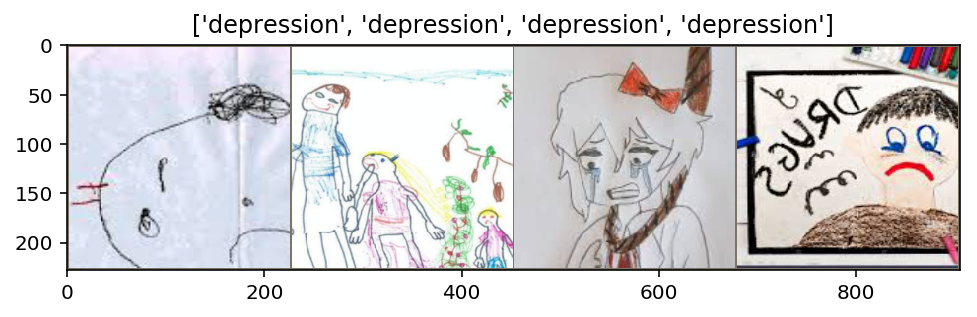

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])

**Creating the model:**

In [16]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:09<00:00, 24316135.17it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

# our input_size matches the in_features of pretrained model


from collections import OrderedDict


# creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))



# replacing the pretrained model classifier with our classifier
model.fc = classifier

**Training the model:**

In [0]:
'''
  Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
        
    '''
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                # Clean existing gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                  
                  # Forward pass - compute outputs on input data using the model
                    outputs = model(inputs)
                    
                     # Compute loss
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                      
                      # Backpropagate the gradients
                        loss.backward()
                        
                        # Update the parameters
                        optimizer.step()

                # statistics
                
                 # Compute the total loss for the batch and add it to train_loss
                running_loss += loss.item() * inputs.size(0)
                
                # Compute the accuracy
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            # Convert correct_counts to float and then compute the mean
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [46]:
#Train a model with a pre-trained network
num_epochs = 5
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()
    

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

 #Adam optimizer with a learning rate (adapts the learning rate for each parameter individually)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.fc.parameters(), lr = .1, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------
Train Loss: 0.6292 Acc: 0.6599
Valid Loss: 0.5205 Acc: 0.7168
()
Epoch 2/10
----------
Train Loss: 0.5457 Acc: 0.7360
Valid Loss: 0.4162 Acc: 0.8584
()
Epoch 3/10
----------
Train Loss: 0.4550 Acc: 0.7868
Valid Loss: 0.4047 Acc: 0.8230
()
Epoch 4/10
----------
Train Loss: 0.5441 Acc: 0.7208
Valid Loss: 0.5073 Acc: 0.7345
()
Epoch 5/10
----------
Train Loss: 0.5005 Acc: 0.7411
Valid Loss: 0.4421 Acc: 0.8230
()
Epoch 6/10
----------
Train Loss: 0.4502 Acc: 0.7919
Valid Loss: 0.3967 Acc: 0.8407
()
Epoch 7/10
----------
Train Loss: 0.4444 Acc: 0.7716
Valid Loss: 0.4280 Acc: 0.8142
()
Epoch 8/10
----------
Train Loss: 0.4502 Acc: 0.7868
Valid Loss: 0.4259 Acc: 0.8053
()
Epoch 9/10
----------
Train Loss: 0.4363 Acc: 0.8020
Valid Loss: 0.3993 Acc: 0.8496
()
Epoch 10/10
----------
Train Loss: 0.4270 Acc: 0.7919
Valid Loss: 0.4125 Acc: 0.8142
()
Training complete in 1m 35s
Best valid accuracy: 0.858407


**Validation:**

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  # Set to evaluation mode
  model.eval()
  
  accuracy = 0
  
  model.to(device)
  # Validation loop
  for images, labels in dataloaders['Valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass - compute outputs on input data using the model
    output = model.forward(images)
    
    # Find average training loss and training accuracy
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['Valid'])))

In [48]:
test(model, dataloaders, device)

Testing Accuracy: 0.017
Testing Accuracy: 0.052
Testing Accuracy: 0.086
Testing Accuracy: 0.112
Testing Accuracy: 0.147
Testing Accuracy: 0.164
Testing Accuracy: 0.198
Testing Accuracy: 0.224
Testing Accuracy: 0.250
Testing Accuracy: 0.284
Testing Accuracy: 0.319
Testing Accuracy: 0.353
Testing Accuracy: 0.379
Testing Accuracy: 0.414
Testing Accuracy: 0.440
Testing Accuracy: 0.474
Testing Accuracy: 0.509
Testing Accuracy: 0.543
Testing Accuracy: 0.578
Testing Accuracy: 0.603
Testing Accuracy: 0.629
Testing Accuracy: 0.655
Testing Accuracy: 0.681
Testing Accuracy: 0.698
Testing Accuracy: 0.733
Testing Accuracy: 0.767
Testing Accuracy: 0.802
Testing Accuracy: 0.828
Testing Accuracy: 0.862


In [0]:
# Save the checkpoint 


model.class_to_idx = dataloaders['Train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['Train'].batch_size,
                  'output_size':3,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'emotions80_checkpoint.pth')

In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 5
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(1024, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('emotions80_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set to evaluation mode
    model.eval()
    
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
      # Validation loop
        for i, (inputs, labels) in enumerate(dataloaders['Valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Calculate validation accuracy
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

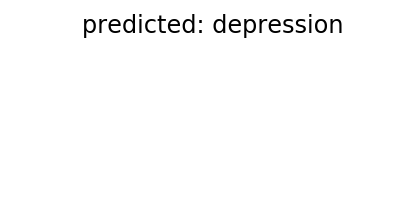

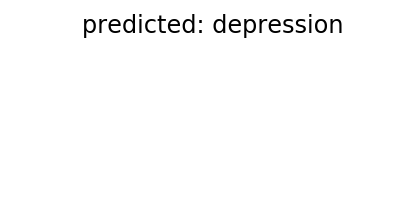

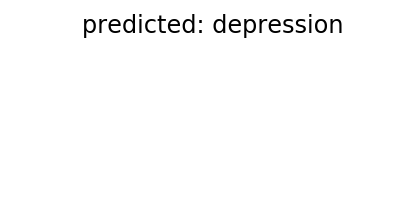

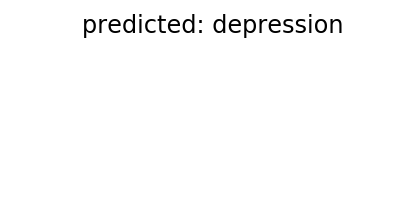

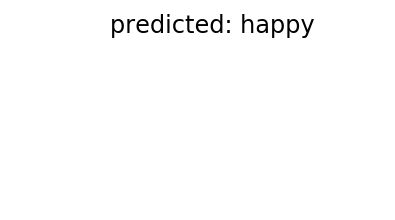

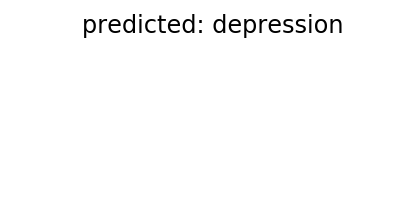

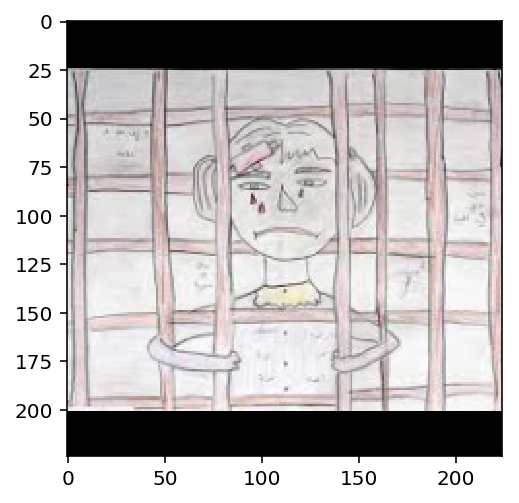

In [57]:
visualize_model(model_ft)

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 361, 361
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_probability, top_class

In [61]:
print (predict('Children_emotions/Valid/happiness/25.jpg', loaded_model))

(array([0.6611941, 0.3388059], dtype=float32), ['happy', 'depression'])


In [0]:
# Display an image along with the top  classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = 'Prediction'
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10),  ncols=1, nrows=2)
    ct_name = img_filename
    
    ax1.set_title(ct_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities, color='blue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(x for x in classes)
    ax2.invert_yaxis()

**Making predictions:**

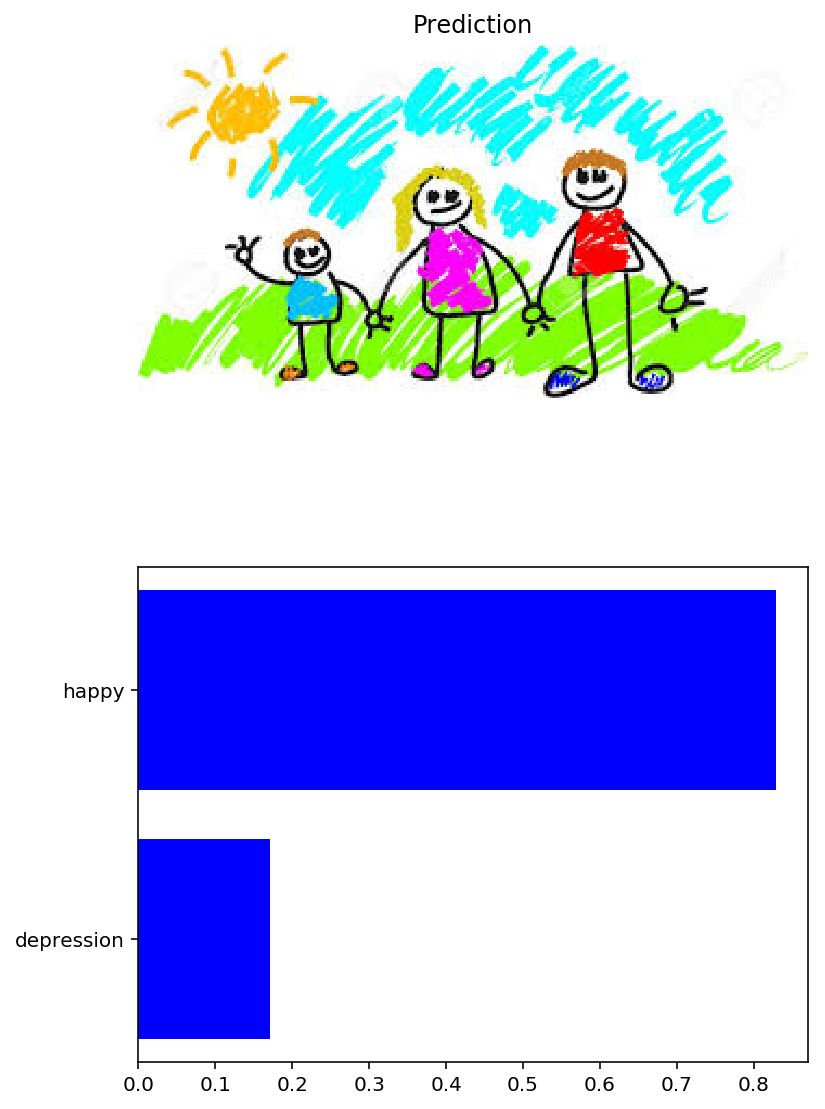

In [63]:
img = 'Children_emotions/Valid/happiness/31.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

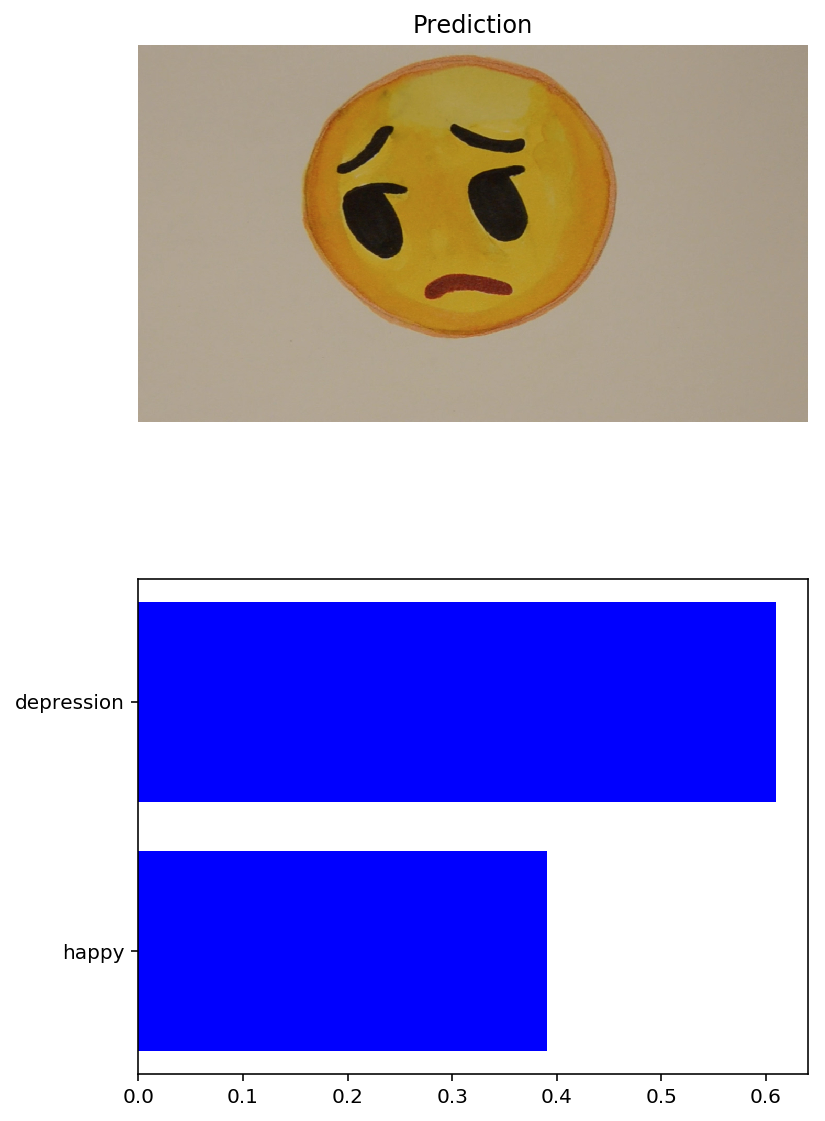

In [64]:
img = 'Children_emotions/Valid/depression/5.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

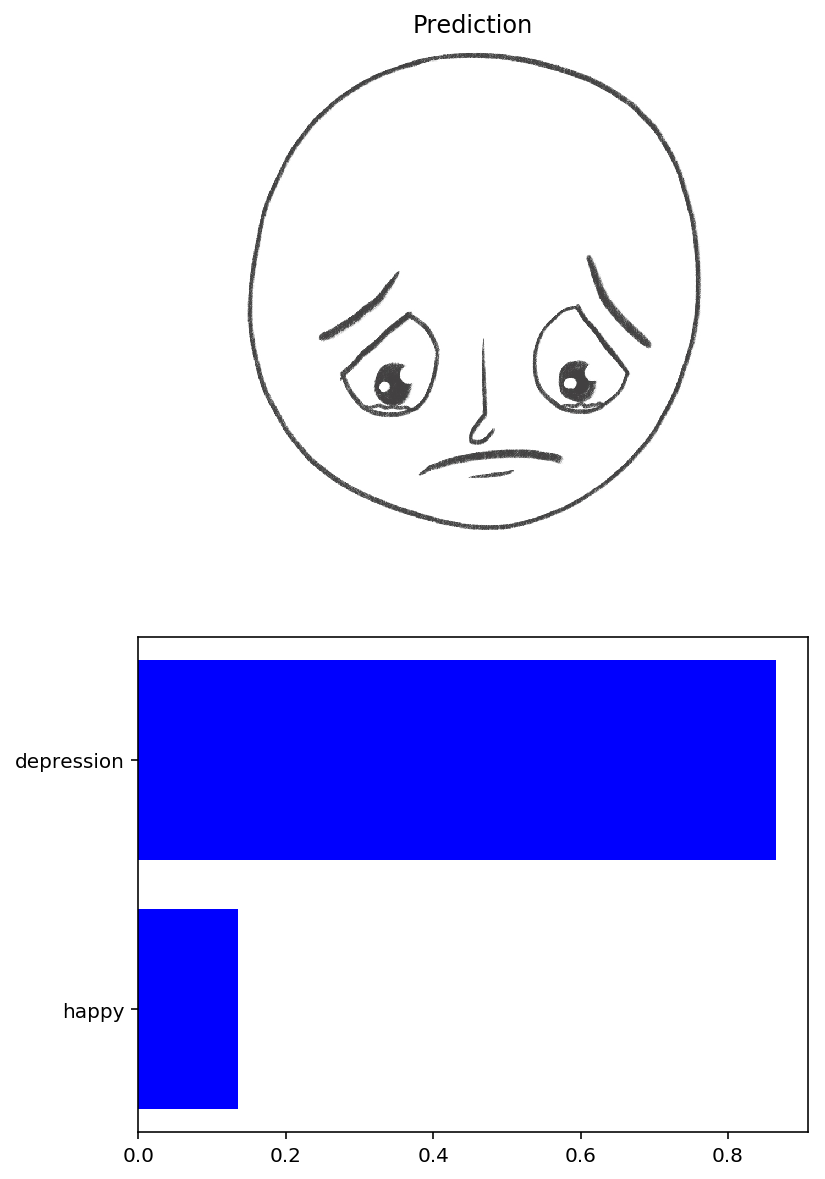

In [65]:
img = 'Children_emotions/Valid/depression/14.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
# replacing the pretrained model classifier with our classifier
model.fc = classifier

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

model.to(device);

#Train the model
#Ie. for epoch in range(epochs):
#     for inputs, labels in trainloader:
#         steps += 1
#         # Move input and label tensors to the default device
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         logps = model.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()
#       ....... REFER to GitHub for full train source code

# Save the model
torch_model=torch.save(model.fc.state_dict(),'emotions_80_checkpoint.pth')

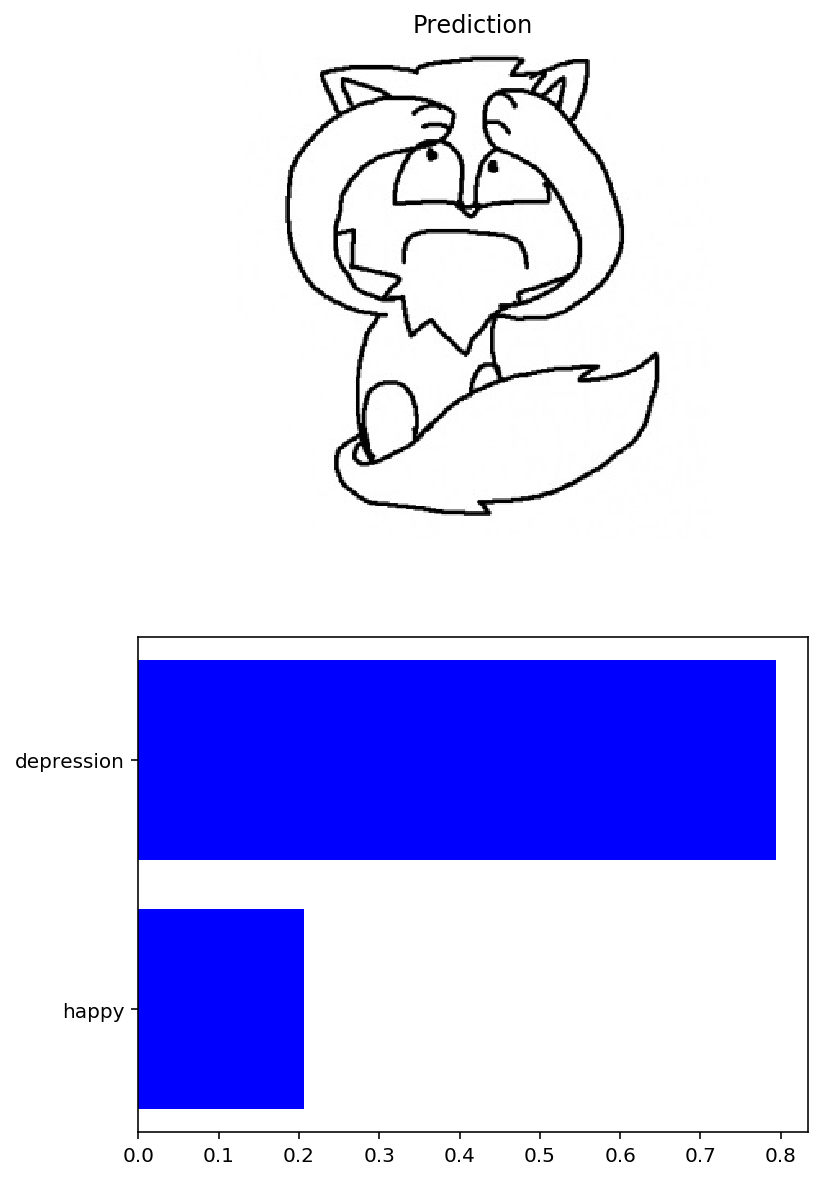

In [68]:
img = 'Children_emotions/Valid/depression/20.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)

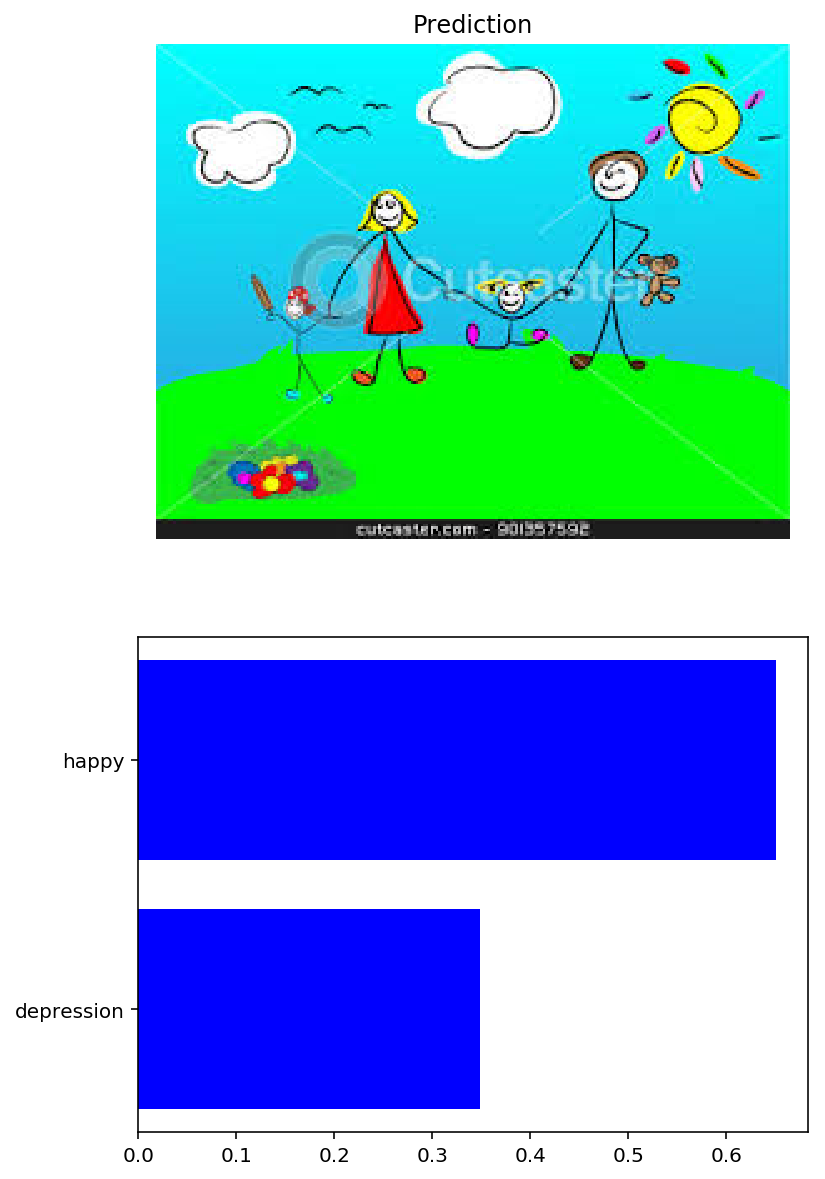

In [69]:
img = 'Children_emotions/Valid/happiness/13.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, class_names)